In [1]:
import sys
sys.path.append('../')
from utils import *
from model import *

In [2]:
data_dir = '/datadrive/data_med/'
batch_size = 256
batch_num  = 128
epoch_num  = 200
samp_num   = 7

device = torch.device("cuda:0")
graph = dill.load(open(data_dir + 'graph.pk', 'rb'))

In [3]:
train_range = {t: True for t in graph.times if t != None and t < 2015}
valid_range = {t: True for t in graph.times if t != None and t >= 2015  and t <= 2016}
test_range  = {t: True for t in graph.times if t != None and t > 2016}

In [4]:
def pf_sample(seed, papers, pairs, t_range, batch_size, test = False):
    np.random.seed(seed)
    _time = np.random.choice(list(papers.keys()))
    sampn = min(len(papers[_time]), batch_size)
    pids = np.array(papers[_time])[np.random.choice(len(papers[_time]), sampn, replace = False)]
    fids = []
    edge = defaultdict(lambda: {})
    for x_id, p_id in enumerate(pids):
        f_ids = pairs[p_id]
        for f_id in f_ids:
            if f_id not in fids:
                fids += [f_id]
            edge[x_id][fids.index(f_id)] = True
    pids = np.stack([pids, np.repeat([_time], sampn)]).T
    fids = np.stack([fids, np.repeat([_time], len(fids))]).T
 
    feature, times, edge_list, _ = sample_subgraph(graph, t_range, \
                inp = {'paper': pids, 'venue': fids}, sampled_depth = 3, sampled_number = 100)

    el = []
    for i in edge_list['paper']['venue']['rev_PV_Journal']:
        if i[0] in edge and i[1] in edge[i[0]]:
            continue
        el += [i]
    edge_list['paper']['venue']['rev_PV_Journal'] = el

    el = []
    for i in edge_list['venue']['paper']['PV_Journal']:
        if i[1] in edge and i[0] in edge[i[1]]:
            continue
        el += [i]
    edge_list['venue']['paper']['PV_Journal'] = el
    
    
    node_feature, node_type, edge_time, edge_index, edge_type, node_dict, edge_dict = \
            to_torch(feature, times, edge_list, graph)
    '''
        Trace the paper_id and venue_id by its own index plus the type start index
    '''
    paper_ids = np.arange(len(pids)) + node_dict['paper'][0]
    venue_ids = np.arange(len(fids)) + node_dict['venue'][0]
    ylabel = torch.zeros(sampn, len(cand_list))
    for x_id, p_id in enumerate(pids[:,0]):
        for f_id in pairs[p_id]:
            ylabel[x_id][cand_list.index(f_id)] = 1
    ylabel /= ylabel.sum(axis=1).view(-1, 1)
    return node_feature, node_type, edge_time, edge_index, edge_type, venue_ids, paper_ids, ylabel
    
def prepare_data(pool, process_ids):
    jobs = []
    for process_id in process_ids[:-1]:
        p = pool.apply_async(pf_sample, args=(np.random.randint(2**32 - 1), train_papers, \
                                               train_pairs, train_range, batch_size))
        jobs.append(p)
    p = pool.apply_async(pf_sample, args=(np.random.randint(2**32 - 1), valid_papers, \
                                           valid_pairs, valid_range, batch_size))
    jobs.append(p)
    return jobs

In [5]:
# class RAGCNConv(MessagePassing):
#     def __init__(self, in_dim, out_dim, num_types, num_relations, n_heads, dropout = 0.3, **kwargs):
#         super(RAGCNConv, self).__init__(aggr='add', **kwargs)

#         self.in_dim        = in_dim
#         self.out_dim       = out_dim
#         self.num_types     = num_types
#         self.num_relations = num_relations
#         self.total_rel     = num_types * num_relations * num_types
#         self.n_heads       = n_heads
#         self.d_k           = out_dim // n_heads
#         self.sqrt_dk       = math.sqrt(self.d_k)
#         self.att           = None
        
#         self.interact_sw   = nn.Linear(in_dim,   out_dim)
#         self.interact_tw   = nn.Linear(in_dim,   out_dim)
#         self.transfer_sw   = nn.Linear(in_dim,   out_dim)
        
#         self.aggregat_w   = nn.Linear(out_dim,  out_dim)
#         self.norm         = BatchNorm(out_dim)
        
    

#         self.relation_ws   = nn.Parameter(torch.ones(num_types, num_relations, num_types, self.n_heads))
#         self.interact_rw   = nn.Parameter(torch.Tensor(n_heads, self.d_k, self.d_k))
#         self.transfer_rw   = nn.Parameter(torch.Tensor(n_heads, self.d_k, self.d_k))
        
#         self.drop          = nn.Dropout(dropout)
#         self.emb           = RelTemporalEncoding(in_dim)
        
#         glorot(self.interact_rw)
#         glorot(self.transfer_rw)
        
#     def forward(self, node_inp, node_type, edge_index, edge_type, edge_time):
#         return self.propagate(edge_index, node_inp=node_inp, node_type=node_type, \
#                               edge_type=edge_type, edge_time = edge_time)

#     def message(self, edge_index_i, node_inp_i, node_inp_j, node_type_i, node_type_j, edge_type, edge_time, num_nodes):
#         '''
#             i: target; j: source
#         '''
#         data_size = edge_index_i.size(0)
#         atts, vals = [], []
#         res_att     = torch.zeros(data_size, self.n_heads).to(node_inp_i.device)
#         res_val     = torch.zeros(data_size, self.n_heads, self.d_k).to(node_inp_i.device)
        
#         for source_id in range(self.num_types):
#             sb = node_type_j == source_id
#             interact_sw = self.interact_sw
#             transfer_sw = self.transfer_sw
#             for target_id in range(self.num_types):
#                 tb = (node_type_i == target_id) & sb
#                 interact_tw = self.interact_tw
#                 for relation_id in range(self.num_relations):
#                     idx = tb & (edge_type == relation_id)
#                     if idx.sum() == 0:
#                         continue
#                     _node_inp_i = node_inp_i[idx]
#                     _node_inp_j = self.emb(node_inp_j[idx], edge_time[idx])
                    
#                     _int_i = interact_tw(_node_inp_i).view(-1, self.n_heads, self.d_k)
#                     _int_j = interact_sw(_node_inp_j).view(-1, self.n_heads, self.d_k)
                    
#                     _int_s = torch.bmm(_int_j.transpose(1,0), self.interact_rw).transpose(1,0)
#                     res_att[idx] = (_int_s * _int_i).sum(dim=-1) / self.sqrt_dk
                    
#                     _tra_j = transfer_sw(_node_inp_j).view(-1, self.n_heads, self.d_k)
#                     res_val[idx] = torch.bmm(_tra_j.transpose(1,0), self.transfer_rw).transpose(1,0)
                    
#         self.att = softmax(res_att, edge_index_i, data_size)
#         res = res_val * self.att.view(-1, self.n_heads, 1)
#         del res_att, res_val
#         return res.view(-1, self.out_dim)


#     def update(self, aggr_out, node_inp, node_type):
#         '''
#            x = BN[node_type](W[node_type] * GNN(x) + x)
#         '''
#         res = torch.zeros(aggr_out.size(0), self.out_dim).to(node_inp.device)
#         for t_id in range(self.num_types):
#             aggregat_w = self.aggregat_w
#             norm = self.norm
#             idx = (node_type == t_id)
#             if idx.sum() == 0:
#                 continue
#             res[idx] = norm(F.relu(aggregat_w(aggr_out[idx])) + node_inp[idx])
#         out = self.drop(res)
#         del res
#         return out

#     def __repr__(self):
#         return '{}(in_dim={}, out_dim={}, num_types={}, num_types={})'.format(
#             self.__class__.__name__, self.in_dim, self.out_dim,
#             self.num_types, self.num_relations)

In [6]:
class GNN(nn.Module):
    def __init__(self, in_dim, n_hid, num_types, num_relations, n_heads, n_layers, dropout = 0.3):
        super(GNN, self).__init__()
        self.gcs = nn.ModuleList()
        self.num_types = num_types
        self.in_dim    = in_dim
        self.n_hid     = n_hid
        self.aggregat_ws   = nn.ModuleList()
        self.drop          = nn.Dropout(dropout)
        for t in range(num_types):
            self.aggregat_ws.append(nn.Linear(in_dim, n_hid))
        for l in range(n_layers):
            self.gcs.append(RAGCNConv(n_hid, n_hid, num_types, num_relations, n_heads, dropout))
    def set_device(self, device):
        self.device = device
        for gc in self.gcs:
            gc.device = device
    def forward(self, node_feature, node_type, edge_time, edge_index, edge_type):
        res = torch.zeros(node_feature.size(0), self.n_hid).to(node_feature.device)
        for t_id in range(self.num_types):
            aggregat_w = self.aggregat_ws[t_id]
            idx = (node_type == t_id)
            if idx.sum() == 0:
                continue
            res[idx] = torch.tanh(aggregat_w(node_feature[idx]))
        meta_xs = self.drop(res)
        del res
        for gc in self.gcs:
            meta_xs = gc(meta_xs, node_type, edge_index, edge_type, edge_time)
        return meta_xs

In [7]:
'''
Paper-Venue
'''
paper_ser = {}

train_pairs = {}
valid_pairs = {}
test_pairs  = {}

train_papers = {_time: {} for _time in train_range}
valid_papers = {_time: {} for _time in valid_range}
test_papers  = {_time: {} for _time in test_range}

for f_id in graph.edge_list['venue']['paper']['PV_Journal']:
    for p_id in graph.edge_list['venue']['paper']['PV_Journal'][f_id]:
        _time = graph.edge_list['venue']['paper']['PV_Journal'][f_id][p_id]
        if _time in train_range:
            if p_id not in train_pairs:
                train_pairs[p_id] = []
            train_pairs[p_id] += [f_id]
            train_papers[_time][p_id] = True
        elif _time in valid_range:
            if p_id not in valid_pairs:
                valid_pairs[p_id] = []
            valid_pairs[p_id] += [f_id]
            valid_papers[_time][p_id] = True
        else:
            if p_id not in test_pairs:
                test_pairs[p_id] = []
            test_pairs[p_id] += [f_id]
            test_papers[_time][p_id] = True
for _time in list(train_papers.keys()):
    if len(train_papers[_time]) < batch_size // 2:
        train_papers.pop(_time)
    else:
        train_papers[_time] = np.array(list(train_papers[_time].keys()))
for _time in list(valid_papers.keys()):
    if len(valid_papers[_time]) < batch_size // 2:
        valid_papers.pop(_time)
    else:
        valid_papers[_time] = np.array(list(valid_papers[_time].keys()))
for _time in list(test_papers.keys()):
    if len(test_papers[_time]) < batch_size // 2:
        test_papers.pop(_time)
    else:
        test_papers[_time] = np.array(list(test_papers[_time].keys()))

In [8]:
types = graph.get_types()
cand_list = list(graph.edge_list['venue']['paper']['PV_Journal'])
gnn = GNN(in_dim = len(graph.node_feature['paper']['emb'][0]) + 401, n_hid = 256, num_types = len(types), \
          num_relations = len(graph.get_meta_graph()) + 1, n_heads = 8, n_layers = 3).to(device)
# gnn = torch.load('../pre-train/save/cpc_model.pt').to(device)
classifier = Classifier(256, len(cand_list)).to(device)
model = nn.Sequential(gnn, classifier)
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000, eta_min=1e-6)

In [9]:
total_size = 0
for l in gnn.parameters():   
    size = 1
    if l.requires_grad:
        for i in l.shape:
            size *= i
    total_size += size
print(total_size / 1000 / 1000)

8.056248


In [10]:
stats = []
pool = mp.Pool(4)
process_ids = np.arange(batch_num // 4)
st = time.time()
jobs = prepare_data(pool, process_ids)
train_step = 1500
best_val   = 0
res = []
criterion = nn.KLDivLoss(reduction='batchmean')
for epoch in np.arange(epoch_num)+1:
    '''
        Prepare Training and Validation Data
    '''
    train_data = [job.get() for job in jobs[:-1]]
    valid_data = jobs[-1].get()
    pool.close()
    pool.join()
    pool = mp.Pool(4)
    jobs = prepare_data(pool, process_ids)
    et = time.time()
    print('Data Preparation: %.1fs' % (et - st))
    
    model.train()
    train_losses = []
    torch.cuda.empty_cache()
    for batch in np.arange(2):
        for node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel in train_data:
            node_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                                   edge_time.to(device), edge_index.to(device), edge_type.to(device))
            res  = classifier.forward(node_rep[paper_ids])
            loss = criterion(res, ylabel.to(device))
            optimizer.zero_grad() 
            torch.cuda.empty_cache()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
            optimizer.step()
            train_losses += [loss.cpu().detach().tolist()]
            train_step += 1
            scheduler.step(train_step)
            del res, loss
    '''
        Valid
    '''
    model.eval()
    with torch.no_grad():
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = valid_data
        node_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                                   edge_time.to(device), edge_index.to(device), edge_type.to(device))
        res  = classifier.forward(node_rep[paper_ids])
        loss = criterion(res, ylabel.to(device))
        valid_res = []

        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            valid_res += [ai[bi].tolist()]
        valid_ndcg = np.average([ndcg_at_k(resi, len(resi)) for resi in valid_res])
        if valid_ndcg > best_val:
            best_val = valid_ndcg
            torch.save(model, './save/rgt_2.pt')
        st = time.time()
        print(("Epoch: %d (%.1fs)  LR: %.5f Train Loss: %.2f  Valid Loss: %.2f  Valid NDCG: %.4f") % \
              (epoch, (st-et), optimizer.param_groups[0]['lr'], np.average(train_losses), loss.cpu().detach().tolist(),\
              valid_ndcg))
        stats += [[np.average(train_losses), loss.cpu().detach().tolist()]]
        del res, loss
        if epoch % 5 == 0:
            '''
                Test
            '''
            _time = np.random.choice(list(test_papers.keys()))
            node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                           test_pairs, test_range, batch_size, test=True)
            paper_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                      edge_time.to(device), edge_index.to(device), edge_type.to(device))[paper_ids]
            res  = classifier.forward(paper_rep)
            test_res = []
            for ai, bi in zip(ylabel, res.argsort(descending = True)):
                test_res += [ai[bi].tolist()]
            test_ndcg = np.average([ndcg_at_k(resi, len(resi)) for resi in test_res])
            print(test_ndcg)
            del res
    del train_data, valid_data

Data Preparation: 270.9s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 (291.0s)  LR: 0.00060 Train Loss: 7.62  Valid Loss: 8.26  Valid NDCG: 0.1201
Data Preparation: 5.5s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 2 (279.4s)  LR: 0.00069 Train Loss: 5.73  Valid Loss: 8.07  Valid NDCG: 0.1435
Data Preparation: 5.7s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 3 (285.3s)  LR: 0.00078 Train Loss: 4.76  Valid Loss: 8.19  Valid NDCG: 0.1508
Data Preparation: 5.8s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 4 (286.4s)  LR: 0.00085 Train Loss: 4.15  Valid Loss: 8.21  Valid NDCG: 0.1530
Data Preparation: 5.5s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 5 (278.5s)  LR: 0.00091 Train Loss: 4.39  Valid Loss: 8.38  Valid NDCG: 0.1605
0.17911613924298786
Data Preparation: 25.8s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 6 (278.7s)  LR: 0.00096 Train Loss: 3.97  Valid Loss: 7.19  Valid NDCG: 0.2116
Data Preparation: 5.5s
Epoch: 7 (284.8s)  LR: 0.00099 Train Loss: 3.34  Valid Loss: 7.36  Valid NDCG: 0.1942
Data Preparation: 5.5s
Epoch: 8 (287.3s)  LR: 0.00100 Train Loss: 3.33  Valid Loss: 7.06  Valid NDCG: 0.2012
Data Preparation: 5.6s
Epoch: 9 (289.6s)  LR: 0.00099 Train Loss: 2.79  Valid Loss: 7.31  Valid NDCG: 0.2088
Data Preparation: 5.3s
Epoch: 10 (277.1s)  LR: 0.00096 Train Loss: 3.51  Valid Loss: 7.24  Valid NDCG: 0.2089
0.2438563664718582
Data Preparation: 27.8s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 11 (278.9s)  LR: 0.00092 Train Loss: 3.41  Valid Loss: 6.93  Valid NDCG: 0.2444
Data Preparation: 5.6s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 12 (277.5s)  LR: 0.00086 Train Loss: 3.04  Valid Loss: 6.41  Valid NDCG: 0.2807
Data Preparation: 5.6s
Epoch: 13 (276.2s)  LR: 0.00079 Train Loss: 2.92  Valid Loss: 6.41  Valid NDCG: 0.2712
Data Preparation: 5.7s
Epoch: 14 (275.7s)  LR: 0.00070 Train Loss: 2.58  Valid Loss: 6.55  Valid NDCG: 0.2789
Data Preparation: 5.5s
Epoch: 15 (276.2s)  LR: 0.00061 Train Loss: 2.70  Valid Loss: 6.94  Valid NDCG: 0.2401
0.32781233737130455
Data Preparation: 26.5s
Epoch: 16 (283.1s)  LR: 0.00051 Train Loss: 2.28  Valid Loss: 6.51  Valid NDCG: 0.2793
Data Preparation: 5.5s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 17 (275.8s)  LR: 0.00042 Train Loss: 2.94  Valid Loss: 6.37  Valid NDCG: 0.2973
Data Preparation: 5.7s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 18 (286.4s)  LR: 0.00032 Train Loss: 2.11  Valid Loss: 6.03  Valid NDCG: 0.3212
Data Preparation: 5.5s
Epoch: 19 (274.7s)  LR: 0.00024 Train Loss: 2.68  Valid Loss: 6.13  Valid NDCG: 0.3074
Data Preparation: 5.5s
Epoch: 20 (279.3s)  LR: 0.00016 Train Loss: 2.12  Valid Loss: 6.16  Valid NDCG: 0.2907
0.359436572980566
Data Preparation: 25.8s
Epoch: 21 (271.7s)  LR: 0.00009 Train Loss: 2.78  Valid Loss: 6.50  Valid NDCG: 0.2987
Data Preparation: 5.7s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 22 (285.8s)  LR: 0.00005 Train Loss: 1.87  Valid Loss: 5.85  Valid NDCG: 0.3454
Data Preparation: 5.7s
Epoch: 23 (277.8s)  LR: 0.00001 Train Loss: 2.47  Valid Loss: 6.66  Valid NDCG: 0.2581
Data Preparation: 5.5s
Epoch: 24 (281.8s)  LR: 0.00000 Train Loss: 2.19  Valid Loss: 6.39  Valid NDCG: 0.3045
Data Preparation: 5.8s
Epoch: 25 (286.9s)  LR: 0.00001 Train Loss: 2.03  Valid Loss: 6.59  Valid NDCG: 0.2711
0.2846642674666916
Data Preparation: 25.9s
Epoch: 26 (276.9s)  LR: 0.00003 Train Loss: 2.50  Valid Loss: 6.32  Valid NDCG: 0.3135
Data Preparation: 5.7s
Epoch: 27 (278.3s)  LR: 0.00007 Train Loss: 2.39  Valid Loss: 6.16  Valid NDCG: 0.3087
Data Preparation: 5.5s
Epoch: 28 (273.5s)  LR: 0.00013 Train Loss: 2.52  Valid Loss: 6.30  Valid NDCG: 0.2998
Data Preparation: 5.7s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 29 (283.6s)  LR: 0.00020 Train Loss: 2.03  Valid Loss: 5.70  Valid NDCG: 0.3611
Data Preparation: 6.1s
Epoch: 30 (280.5s)  LR: 0.00029 Train Loss: 2.16  Valid Loss: 6.57  Valid NDCG: 0.2762
0.3776621224435497
Data Preparation: 26.5s
Epoch: 31 (281.9s)  LR: 0.00038 Train Loss: 1.78  Valid Loss: 6.51  Valid NDCG: 0.2931
Data Preparation: 5.7s
Epoch: 32 (277.3s)  LR: 0.00048 Train Loss: 2.55  Valid Loss: 5.70  Valid NDCG: 0.3563
Data Preparation: 5.5s
Epoch: 33 (281.5s)  LR: 0.00057 Train Loss: 1.84  Valid Loss: 5.83  Valid NDCG: 0.3335
Data Preparation: 5.5s
Epoch: 34 (277.1s)  LR: 0.00067 Train Loss: 2.31  Valid Loss: 6.17  Valid NDCG: 0.3209
Data Preparation: 5.6s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 35 (276.9s)  LR: 0.00075 Train Loss: 2.58  Valid Loss: 5.93  Valid NDCG: 0.3697
0.3925798481524829
Data Preparation: 26.8s
Epoch: 36 (283.2s)  LR: 0.00083 Train Loss: 1.86  Valid Loss: 6.23  Valid NDCG: 0.3239
Data Preparation: 5.8s
Epoch: 37 (284.8s)  LR: 0.00090 Train Loss: 1.82  Valid Loss: 5.73  Valid NDCG: 0.3627
Data Preparation: 5.8s
Epoch: 38 (275.8s)  LR: 0.00095 Train Loss: 2.29  Valid Loss: 5.76  Valid NDCG: 0.3292
Data Preparation: 6.0s
Epoch: 39 (277.7s)  LR: 0.00098 Train Loss: 2.23  Valid Loss: 6.12  Valid NDCG: 0.3084
Data Preparation: 5.6s
Epoch: 40 (284.0s)  LR: 0.00100 Train Loss: 1.98  Valid Loss: 5.93  Valid NDCG: 0.3489
0.3426185644836568
Data Preparation: 26.2s
Epoch: 41 (278.2s)  LR: 0.00100 Train Loss: 2.13  Valid Loss: 5.98  Valid NDCG: 0.3287
Data Preparation: 5.7s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 42 (276.7s)  LR: 0.00097 Train Loss: 1.92  Valid Loss: 5.47  Valid NDCG: 0.3826
Data Preparation: 5.9s
Epoch: 43 (275.9s)  LR: 0.00093 Train Loss: 1.81  Valid Loss: 6.37  Valid NDCG: 0.3121
Data Preparation: 5.8s
Epoch: 44 (280.8s)  LR: 0.00088 Train Loss: 2.15  Valid Loss: 5.94  Valid NDCG: 0.3200
Data Preparation: 5.8s
Epoch: 45 (279.6s)  LR: 0.00081 Train Loss: 1.93  Valid Loss: 5.61  Valid NDCG: 0.3728
0.38433973929267434
Data Preparation: 26.2s
Epoch: 46 (281.9s)  LR: 0.00072 Train Loss: 1.79  Valid Loss: 5.84  Valid NDCG: 0.3668
Data Preparation: 6.0s
Epoch: 47 (275.0s)  LR: 0.00063 Train Loss: 2.19  Valid Loss: 6.12  Valid NDCG: 0.3136
Data Preparation: 6.2s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 48 (274.3s)  LR: 0.00054 Train Loss: 2.16  Valid Loss: 5.43  Valid NDCG: 0.3840
Data Preparation: 6.1s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 49 (273.8s)  LR: 0.00044 Train Loss: 2.17  Valid Loss: 5.41  Valid NDCG: 0.3851
Data Preparation: 6.2s
Epoch: 50 (277.9s)  LR: 0.00035 Train Loss: 1.78  Valid Loss: 5.57  Valid NDCG: 0.3748
0.4642002888848862
Data Preparation: 25.7s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 51 (280.1s)  LR: 0.00026 Train Loss: 1.60  Valid Loss: 5.42  Valid NDCG: 0.4090
Data Preparation: 6.3s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 52 (280.7s)  LR: 0.00018 Train Loss: 1.69  Valid Loss: 4.87  Valid NDCG: 0.4364
Data Preparation: 6.2s
Epoch: 53 (279.4s)  LR: 0.00011 Train Loss: 1.69  Valid Loss: 5.68  Valid NDCG: 0.3686
Data Preparation: 6.4s
Epoch: 54 (275.7s)  LR: 0.00006 Train Loss: 1.72  Valid Loss: 5.33  Valid NDCG: 0.4053
Data Preparation: 6.6s
Epoch: 55 (286.3s)  LR: 0.00002 Train Loss: 1.47  Valid Loss: 5.56  Valid NDCG: 0.4063
0.43723931072676014
Data Preparation: 27.1s
Epoch: 56 (287.8s)  LR: 0.00000 Train Loss: 1.36  Valid Loss: 5.12  Valid NDCG: 0.4202
Data Preparation: 6.5s
Epoch: 57 (275.2s)  LR: 0.00000 Train Loss: 1.91  Valid Loss: 5.38  Valid NDCG: 0.3848
Data Preparation: 6.6s
Epoch: 58 (281.5s)  LR: 0.00002 Train Loss: 1.73  Valid Loss: 5.03  Valid NDCG: 0.4315
Data Preparation: 6.8s
Epoch: 59 (284.3s)  LR: 0.00006 Train Loss: 1.78  Valid Loss: 5.79  Valid NDCG: 0.3302
Data Preparation: 6.4s
Epoch: 60 (287.8s)  LR: 0.00012 Train Loss: 1.46  Valid Loss: 5.34  Valid NDCG: 0.3705
0.4628622016

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 71 (277.5s)  LR: 0.00098 Train Loss: 1.78  Valid Loss: 5.08  Valid NDCG: 0.4414
Data Preparation: 6.2s
Epoch: 72 (273.5s)  LR: 0.00100 Train Loss: 1.94  Valid Loss: 5.34  Valid NDCG: 0.3904
Data Preparation: 6.4s
Epoch: 73 (274.2s)  LR: 0.00100 Train Loss: 1.93  Valid Loss: 5.05  Valid NDCG: 0.4210
Data Preparation: 6.2s
Epoch: 74 (283.4s)  LR: 0.00098 Train Loss: 1.59  Valid Loss: 5.30  Valid NDCG: 0.4170
Data Preparation: 6.0s
Epoch: 75 (269.4s)  LR: 0.00095 Train Loss: 2.22  Valid Loss: 5.00  Valid NDCG: 0.4376
0.48144099966743453
Data Preparation: 26.5s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 76 (270.9s)  LR: 0.00089 Train Loss: 1.73  Valid Loss: 4.84  Valid NDCG: 0.4488
Data Preparation: 6.5s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 77 (280.3s)  LR: 0.00083 Train Loss: 1.26  Valid Loss: 4.94  Valid NDCG: 0.4602
Data Preparation: 6.5s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 78 (282.6s)  LR: 0.00075 Train Loss: 1.55  Valid Loss: 4.37  Valid NDCG: 0.4885
Data Preparation: 6.2s
Epoch: 79 (269.6s)  LR: 0.00066 Train Loss: 2.06  Valid Loss: 5.44  Valid NDCG: 0.4322
Data Preparation: 6.4s
Epoch: 80 (274.5s)  LR: 0.00056 Train Loss: 1.68  Valid Loss: 5.59  Valid NDCG: 0.3725
0.5083693961117537
Data Preparation: 27.7s
Epoch: 81 (270.0s)  LR: 0.00047 Train Loss: 1.88  Valid Loss: 5.03  Valid NDCG: 0.4355
Data Preparation: 6.2s
Epoch: 82 (280.2s)  LR: 0.00037 Train Loss: 1.24  Valid Loss: 5.00  Valid NDCG: 0.4193
Data Preparation: 6.3s
Epoch: 83 (271.1s)  LR: 0.00028 Train Loss: 1.84  Valid Loss: 4.89  Valid NDCG: 0.4502
Data Preparation: 6.3s
Epoch: 84 (269.7s)  LR: 0.00020 Train Loss: 1.78  Valid Loss: 4.66  Valid NDCG: 0.4543
Data Preparation: 6.3s
Epoch: 85 (281.1s)  LR: 0.00013 Train Loss: 1.38  Valid Loss: 5.51  Valid NDCG: 0.4051
0.5029790648781862
Data Preparation: 27.0s
Epoch: 86 (277.4s)  LR: 0.00007 Train Loss: 1.42  Valid Loss: 5.25  Valid NDCG: 

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 87 (279.2s)  LR: 0.00003 Train Loss: 1.66  Valid Loss: 4.68  Valid NDCG: 0.4904
Data Preparation: 6.4s
Epoch: 88 (277.2s)  LR: 0.00001 Train Loss: 1.47  Valid Loss: 5.11  Valid NDCG: 0.4451
Data Preparation: 6.5s
Epoch: 89 (271.4s)  LR: 0.00000 Train Loss: 1.59  Valid Loss: 4.57  Valid NDCG: 0.4668
Data Preparation: 6.6s
Epoch: 90 (271.6s)  LR: 0.00002 Train Loss: 1.47  Valid Loss: 4.70  Valid NDCG: 0.4567
0.50818929759442
Data Preparation: 27.6s
Epoch: 91 (270.4s)  LR: 0.00005 Train Loss: 1.92  Valid Loss: 4.89  Valid NDCG: 0.4600
Data Preparation: 6.6s
Epoch: 92 (277.4s)  LR: 0.00010 Train Loss: 1.50  Valid Loss: 4.68  Valid NDCG: 0.4770
Data Preparation: 6.5s
Epoch: 93 (279.5s)  LR: 0.00017 Train Loss: 1.31  Valid Loss: 5.02  Valid NDCG: 0.4393
Data Preparation: 6.1s
Epoch: 94 (271.5s)  LR: 0.00024 Train Loss: 1.60  Valid Loss: 4.52  Valid NDCG: 0.4861
Data Preparation: 6.3s
Epoch: 95 (274.2s)  LR: 0.00033 Train Loss: 1.50  Valid Loss: 4.72  Valid NDCG: 0.4767
0.5305116199224

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 98 (280.9s)  LR: 0.00062 Train Loss: 1.33  Valid Loss: 4.50  Valid NDCG: 0.5140
Data Preparation: 6.3s
Epoch: 99 (273.8s)  LR: 0.00071 Train Loss: 1.49  Valid Loss: 4.88  Valid NDCG: 0.4576
Data Preparation: 6.4s
Epoch: 100 (275.3s)  LR: 0.00079 Train Loss: 1.52  Valid Loss: 4.33  Valid NDCG: 0.4967
0.5080109461097555
Data Preparation: 26.6s
Epoch: 101 (269.4s)  LR: 0.00087 Train Loss: 1.77  Valid Loss: 5.03  Valid NDCG: 0.4529
Data Preparation: 6.7s
Epoch: 102 (282.6s)  LR: 0.00093 Train Loss: 1.33  Valid Loss: 5.34  Valid NDCG: 0.4101
Data Preparation: 6.4s
Epoch: 103 (267.3s)  LR: 0.00097 Train Loss: 2.22  Valid Loss: 4.71  Valid NDCG: 0.4542
Data Preparation: 6.3s
Epoch: 104 (276.7s)  LR: 0.00099 Train Loss: 1.61  Valid Loss: 4.61  Valid NDCG: 0.4719
Data Preparation: 6.3s
Epoch: 105 (276.8s)  LR: 0.00100 Train Loss: 1.53  Valid Loss: 5.08  Valid NDCG: 0.4306
0.5429157561491333
Data Preparation: 27.7s
Epoch: 106 (275.4s)  LR: 0.00099 Train Loss: 1.48  Valid Loss: 4.50  Valid

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 113 (276.7s)  LR: 0.00049 Train Loss: 1.67  Valid Loss: 4.22  Valid NDCG: 0.5335
Data Preparation: 6.5s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 114 (275.9s)  LR: 0.00039 Train Loss: 1.48  Valid Loss: 4.13  Valid NDCG: 0.5429
Data Preparation: 6.8s
Epoch: 115 (277.4s)  LR: 0.00030 Train Loss: 1.44  Valid Loss: 4.81  Valid NDCG: 0.4914
0.5779412351583426
Data Preparation: 27.1s
Epoch: 116 (277.9s)  LR: 0.00022 Train Loss: 1.46  Valid Loss: 4.80  Valid NDCG: 0.4741
Data Preparation: 6.5s
Epoch: 117 (274.3s)  LR: 0.00014 Train Loss: 1.45  Valid Loss: 4.86  Valid NDCG: 0.4704
Data Preparation: 6.9s
Epoch: 118 (272.0s)  LR: 0.00008 Train Loss: 1.62  Valid Loss: 5.13  Valid NDCG: 0.4319
Data Preparation: 6.6s
Epoch: 119 (269.3s)  LR: 0.00004 Train Loss: 1.72  Valid Loss: 4.27  Valid NDCG: 0.5140
Data Preparation: 7.0s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 120 (275.5s)  LR: 0.00001 Train Loss: 1.52  Valid Loss: 4.31  Valid NDCG: 0.5436
0.5283969670634048
Data Preparation: 27.5s
Epoch: 121 (262.3s)  LR: 0.00000 Train Loss: 1.92  Valid Loss: 4.34  Valid NDCG: 0.5050
Data Preparation: 6.6s
Epoch: 122 (278.6s)  LR: 0.00001 Train Loss: 1.35  Valid Loss: 4.50  Valid NDCG: 0.4949
Data Preparation: 6.6s
Epoch: 123 (276.3s)  LR: 0.00004 Train Loss: 1.36  Valid Loss: 4.16  Valid NDCG: 0.5356
Data Preparation: 6.3s
Epoch: 124 (272.3s)  LR: 0.00009 Train Loss: 1.66  Valid Loss: 4.46  Valid NDCG: 0.4958
Data Preparation: 6.3s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 125 (278.5s)  LR: 0.00015 Train Loss: 1.44  Valid Loss: 3.93  Valid NDCG: 0.5750
0.5355531559258551
Data Preparation: 27.4s
Epoch: 126 (271.3s)  LR: 0.00022 Train Loss: 1.52  Valid Loss: 3.96  Valid NDCG: 0.5455
Data Preparation: 6.8s
Epoch: 127 (276.4s)  LR: 0.00031 Train Loss: 1.31  Valid Loss: 4.52  Valid NDCG: 0.5087
Data Preparation: 6.8s
Epoch: 128 (275.1s)  LR: 0.00040 Train Loss: 1.34  Valid Loss: 4.41  Valid NDCG: 0.5105
Data Preparation: 7.1s
Epoch: 129 (270.5s)  LR: 0.00050 Train Loss: 1.65  Valid Loss: 4.58  Valid NDCG: 0.4698
Data Preparation: 6.9s
Epoch: 130 (269.6s)  LR: 0.00059 Train Loss: 1.77  Valid Loss: 4.34  Valid NDCG: 0.5039
0.5125350234971151
Data Preparation: 28.0s
Epoch: 131 (281.2s)  LR: 0.00069 Train Loss: 1.16  Valid Loss: 4.78  Valid NDCG: 0.4773
Data Preparation: 7.0s
Epoch: 132 (272.9s)  LR: 0.00077 Train Loss: 1.61  Valid Loss: 4.69  Valid NDCG: 0.4656
Data Preparation: 6.6s
Epoch: 133 (276.5s)  LR: 0.00085 Train Loss: 1.17  Valid Loss: 4.34  Val

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 161 (272.9s)  LR: 0.00047 Train Loss: 1.34  Valid Loss: 3.77  Valid NDCG: 0.5872
Data Preparation: 6.7s
Epoch: 162 (268.7s)  LR: 0.00057 Train Loss: 1.45  Valid Loss: 4.67  Valid NDCG: 0.4797
Data Preparation: 6.7s
Epoch: 163 (270.1s)  LR: 0.00066 Train Loss: 1.39  Valid Loss: 4.45  Valid NDCG: 0.4786
Data Preparation: 6.9s
Epoch: 164 (274.5s)  LR: 0.00075 Train Loss: 1.33  Valid Loss: 4.55  Valid NDCG: 0.4823
Data Preparation: 6.9s
Epoch: 165 (266.4s)  LR: 0.00083 Train Loss: 1.82  Valid Loss: 4.71  Valid NDCG: 0.4694
0.5792299278751738
Data Preparation: 26.6s
Epoch: 166 (265.4s)  LR: 0.00090 Train Loss: 1.83  Valid Loss: 4.48  Valid NDCG: 0.4914
Data Preparation: 6.7s
Epoch: 167 (267.1s)  LR: 0.00095 Train Loss: 1.64  Valid Loss: 4.25  Valid NDCG: 0.5305
Data Preparation: 6.8s
Epoch: 168 (271.7s)  LR: 0.00098 Train Loss: 1.37  Valid Loss: 4.82  Valid NDCG: 0.4778
Data Preparation: 6.7s
Epoch: 169 (275.7s)  LR: 0.00100 Train Loss: 1.23  Valid Loss: 4.35  Valid NDCG: 0.5069
Data

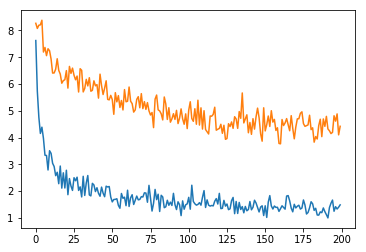

In [11]:
stats = np.array(stats)
plt.plot(stats[:,0])
plt.plot(stats[:,1])
plt.show()

In [12]:
model.eval()
gnn, classifier = model
with torch.no_grad():
    test_res = []
    for _ in range(10):
        _time = np.random.choice(list(test_papers.keys()))
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                       test_pairs, test_range, batch_size, test=True)
        paper_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                      edge_time.to(device), edge_index.to(device), edge_type.to(device))[paper_ids]
        res = classifier.forward(paper_rep)
        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            test_res += [ai[bi].tolist()]
    test_ndcg = [ndcg_at_k(resi, len(resi)) for resi in test_res]
    print(np.average(test_ndcg), np.var(test_ndcg))
    test_mrr = mean_reciprocal_rank(test_res)
    print(np.average(test_mrr), np.var(test_mrr))

0.5610165953913713 0.1580046772348867
0.43958718947136016 0.20178621711110983


In [13]:
best_model = torch.load('./save/rgt_2.pt')

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()

In [ ]:
print(1)

In [ ]:
iris.label

In [14]:
best_model.eval()
gnn, classifier = best_model
with torch.no_grad():
    test_res = []
    for _ in range(10):
        _time = np.random.choice(list(test_papers.keys()))
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                       test_pairs, test_range, batch_size, test=True)
        paper_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                      edge_time.to(device), edge_index.to(device), edge_type.to(device))[paper_ids]
        res = classifier.forward(paper_rep)
        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            test_res += [ai[bi].tolist()]
    test_ndcg = [ndcg_at_k(resi, len(resi)) for resi in test_res]
    print(np.average(test_ndcg), np.var(test_ndcg))
    test_mrr = mean_reciprocal_rank(test_res)
    print(np.average(test_mrr), np.var(test_mrr))

0.5446488079714522 0.15889689245511424
0.4251208434273849 0.20238461459614615


In [ ]:
types = graph.get_types()
cand_list = list(graph.edge_list['venue']['paper']['PV_Journal'])
gnn2 = GNN(in_dim = len(graph.node_feature['paper']['emb'][0]) + 401, n_hid = 256, num_types = len(types), \
          num_relations = len(graph.get_meta_graph()) + 1, n_heads = 8, n_layers = 3).to(device)